In [54]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import os
import json
import csv

In [55]:
def max_abs_scale(series):
    return series / series.abs().max()

# text_order = ["1ko", "5ko", "12ko"]

text_order = ["1Ko", "5Ko", "12Ko"]


color_mapping = {
    "S1": "#17becf",
    "S2": "#ff7f0e",
    "S3": "#f0e68c",
    "S4": "#27ae60",
    "S5": "#708090",
}

bar_width = 0.14

Energy

In [56]:
headers = ['duration_seconds', 'cpu0_package_joules', 'cpu0_dram_joules', 'cpu1_package_joules', 'cpu1_dram_joules', 'schema', 'text']
data = []

for dir in os.listdir("result/energy"):
    # For each subfolder in Energy folder (1Mb.JPEG)
        dir_path = os.path.join("result/energy", dir)
        schema = dir

        for file in os.listdir(dir_path):
            # For each file in the subfolder (pillow1Mb.JPEG.txt)
            file_paht = os.path.join(dir_path, file)
            text = file.replace(".txt", "")

            with open(file_paht, 'r') as file:
                lines = file.readlines()
            
            for line in lines:
                line = line.strip()
                if line.startswith('duration_seconds'):
                    duration_seconds = line.split('=')[1]
                elif line.startswith('cpu0_package_joules'):
                    cpu0_package_joules = line.split('=')[1]
                elif line.startswith('cpu0_dram_joules'):
                    cpu0_dram_joules = line.split('=')[1]
                elif line.startswith('cpu1_package_joules'):
                    cpu1_package_joules = line.split('=')[1]
                elif line.startswith('cpu1_dram_joules'):
                    cpu1_dram_joules = line.split('=')[1]

                    # Append the extracted values to the data list
                    data.append([duration_seconds, 
                                cpu0_package_joules, 
                                cpu0_dram_joules, 
                                cpu1_package_joules, 
                                cpu1_dram_joules, 
                                schema, 
                                text])

with open("result/energy.csv", 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Write the header
        writer.writerows(data)    # Write the data

In [57]:
# df = pd.read_csv("result/text-to-speech-perf.csv")
df = pd.read_csv("result/energy.csv")

df["energy"] = df["cpu0_package_joules"] + df["cpu1_package_joules"]
# Replace commas with dots in 'mean_energys' column
# df['mean_energys'] = df['mean_energys'].str.replace(',', '.')

# Convert to float
# df['mean_energys'] = pd.to_numeric(df['mean_energys'], errors='coerce')
df.head()
# df.dtypes

,duration_seconds,cpu0_package_joules,cpu0_dram_joules,cpu1_package_joules,cpu1_dram_joules,schema,text,energy
0,0.972780,94.541931,12.169819,92.795349,11.665959,S1,1Ko,187.337280
1,0.976683,96.332947,12.217111,90.904724,11.626118,S1,1Ko,187.237671
2,0.942367,93.412659,11.788390,87.737244,11.213125,S1,1Ko,181.149903
3,0.951103,94.199646,11.884795,88.579407,11.298668,S1,1Ko,182.779053
4,0.958949,94.920410,12.003997,89.320312,11.423286,S1,1Ko,184.240722


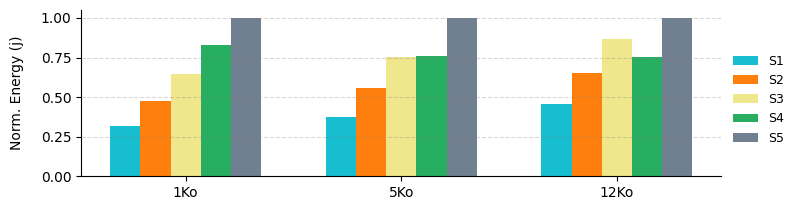

In [58]:
dftt = df.copy()
mean_df = dftt.groupby(['schema', 'text'], as_index=False)['energy'].mean()
mean_df.rename(columns={'energy': 'mean_energys'}, inplace=True)
std_df = dftt.groupby(['schema', 'text'], as_index=False)['energy'].std()
std_df.rename(columns={'energy': 'std_energy'}, inplace=True)

dftt = std_df.merge(mean_df, on=['schema', 'text']) #text --- text

dfe_max_abs = dftt.copy()

dfe_max_abs['mean_energys'] = dfe_max_abs.groupby('text')['mean_energys'].transform(max_abs_scale)

dfe_max_abs['text'] = pd.Categorical(dfe_max_abs['text'], categories=text_order, ordered=True)

dfe_max_abs = dfe_max_abs.sort_values(['schema', 'text'])

# Define the libraries and text sizes
libraries = dfe_max_abs['schema'].unique()
text_sizes = dfe_max_abs['text'].unique()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 2.2))

# Set the positions of the bars on the x-axis
positions = np.arange(len(text_sizes))

# Plot each text size
for i, schema in enumerate(libraries):
    subset = dfe_max_abs[dfe_max_abs['schema'] == schema]
    bar_positions = positions + i * bar_width
    bars = ax.bar(bar_positions, subset['mean_energys'], width=bar_width, label=schema, color=color_mapping[schema])

    # for bar, std in zip(bars, subset['std_energy']):
    #     height = bar.get_height()
    #     ax.annotate(f'{std:.1f}',
    #                 xy=(bar.get_x() + bar.get_width() / 2, height),
    #                 xytext=(0, 3),  # 3 points vertical offset
    #                 textcoords="offset points",
    #                 ha='center', va='bottom',
    #                 fontsize=8, rotation=90)

# Set the labels and title
ax.set_ylabel('Norm. Energy (j)', fontsize=10, labelpad=12) 
ax.spines[['right', 'top']].set_visible(False)

ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)

# Set the x-ticks and labels
ax.set_xticks(positions + bar_width * (len(libraries) - 1) / 2)
ax.set_xticklabels(text_sizes)

ax.legend(
    bbox_to_anchor=(1, 0.8), loc='upper left', ncols = 1, frameon=False, fontsize=9
)
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Times

In [10]:
df = pd.read_csv("result/result.csv")
df["total_time"] = df["process"] + df["pull"] + df["push"]
# df.head()

Compute Time

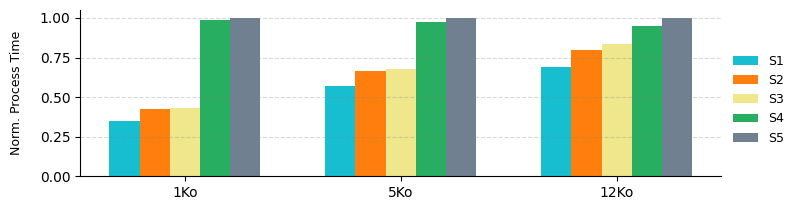

In [7]:
dfct = df.copy()
dfct = dfct.groupby(['schema', 'text'], as_index = False)['process'].mean()
dfct['normalized_compute_time'] = dfct.groupby('text')['process'].transform(max_abs_scale)
dfct['text'] = pd.Categorical(dfct['text'], categories=text_order, ordered=True)
dfct = dfct.sort_values(['schema', 'text'])

# Define the libraries and text sizes #text --- text
libraries = dfct['schema'].unique()
text_sizes = dfct['text'].unique()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 2.2))

# Set the positions of the bars on the x-axis
positions = np.arange(len(text_sizes))

# Plot each text size
for i, schema in enumerate(libraries):
    subset = dfct[dfct['schema'] == schema]
    bar_positions = positions + i * bar_width
    ax.bar(bar_positions, subset['normalized_compute_time'], width=bar_width, label=schema, color=color_mapping[schema])

# Set the labels and title
ax.set_ylabel('Norm. Process Time', fontsize=9, labelpad=12)

ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)

ax.spines[['right', 'top']].set_visible(False)

# Set the x-ticks and labels
ax.set_xticks(positions + bar_width * (len(libraries) - 1) / 2)
ax.set_xticklabels(text_sizes)
ax.legend(
    bbox_to_anchor=(1, 0.8), loc='upper left', ncols = 1, frameon=False, fontsize=9
)

# plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

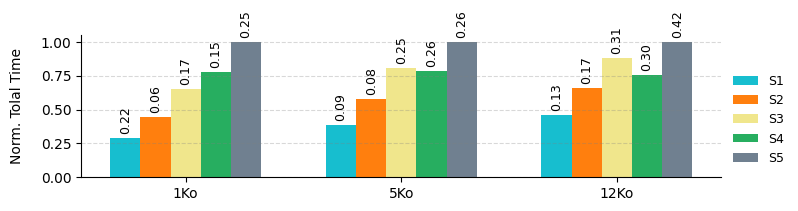

In [9]:
dftt = df.copy()
mean_df = dftt.groupby(['schema', 'text'], as_index=False)['total_time'].mean()
mean_df.rename(columns={'total_time': 'mean_total_time'}, inplace=True)
std_df = dftt.groupby(['schema', 'text'], as_index=False)['total_time'].std()
std_df.rename(columns={'total_time': 'std_total_time'}, inplace=True)

dftt = std_df.merge(mean_df, on=['schema', 'text'])

dftt['normalized_total_time'] = dftt.groupby('text')['mean_total_time'].transform(max_abs_scale)

dftt['text'] = pd.Categorical(dftt['text'], categories=text_order, ordered=True)

dftt = dftt.sort_values(['schema', 'text'])

libraries = dftt['schema'].unique()
text_sizes = dftt['text'].unique()

fig, ax = plt.subplots(figsize=(8, 2.2))

positions = np.arange(len(text_sizes))

for i, schema in enumerate(libraries):
    subset = dftt[dftt['schema'] == schema]
    bar_positions = positions + i * bar_width
    bars = ax.bar(bar_positions, subset['normalized_total_time'], width=bar_width, label=schema, color=color_mapping[schema])

    for bar, std in zip(bars, subset['std_total_time']):
        height = bar.get_height()
        ax.annotate(f'{std:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9, rotation=90)

ax.set_ylabel('Norm. Tolal Time', fontsize=10, labelpad=12)
ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks(positions + bar_width * (len(libraries) - 1) / 2)
ax.set_xticklabels(text_sizes)
ax.legend(
    bbox_to_anchor=(1, 0.8), loc='upper left', ncols = 1, frameon=False, fontsize=9
)

plt.tight_layout()
plt.show()